# **Understanding Word2Vec with Gensim and Elang**

<center><img src="https://i.pinimg.com/originals/93/c1/8c/93c18c82948d55fd95cad43cf63ac28e.png"></center>

Hi! Welcome to my first ever internal training. In this notebook, we'll be discussing about Word Embedding, specifically Word2Vec using `gensim` packages with its application for a recommender system. I will also demonstrate how to use `elang` package for building a corpus and word embedding 2D visualization. Without any further ado, let's get started!

<center><img src="https://raw.githubusercontent.com/tomytjandra/word2vec-embeddings/master/assets/mindmap.png"></center>


First, let's download additional Python packages:

In [0]:
!pip install elang
!pip install contractions
!pip install PyDrive

     |████████████████████████████████| 348kB 2.7MB/s 
     |████████████████████████████████| 245kB 3.6MB/s 
     |████████████████████████████████| 317kB 13.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81691 sha256=958dfe4a8093a50983418482e5e1e1d91249bd85803d534df275d95ca50139c1
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


Next, we create a connection between Google Colab and Drive. **Please go through the authentication step** then download the file using the Google File ID.

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download pre-trained model
# you can replace the id with id of file you want to access
model_id = "1vXsf0DI8HKGuqYFIGIrvG-73KzZPgz5h"
downloaded = drive.CreateFile({'id':model_id})
downloaded.GetContentFile('wiki_Animal.model')

Import necessary Python packages for the content.

In [0]:
# data analysis
import pandas as pd
import numpy as np

# text processing
import nltk
nltk.download(["brown", "stopwords"])
from nltk.corpus import brown
from nltk.probability import FreqDist

# visualization
import matplotlib.pyplot as plt

# misc
from itertools import combinations
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Introduction to Word Embedding**

## **What does it mean?**
Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. It is just a fancy way of saying **numerical representation of words**. A good analogy would be how we use the RGB representation for colors.

## **Why do we need them?**
As a human, it doesn’t make much sense in wanting to represent words using numbers because numbers are used for quantification and why would one need to quantify words?

The answer to that is, we want to **quantify the semantics**. We want to represent words in such a manner that it captures its meaning in a way humans do. Not the exact meaning of the word but a contextual one. For example, when I say the word "see", we know exactly what action — the context — I’m talking about, even though we might not be able to quote its meaning, the kind we would find in a dictionary, of the top of our head.

## **One-hot Vectors**
The simplest word embedding you can have is using one-hot vectors. If you have $n$ words in your vocabulary, then you can represent each word as a $1 \times n$ vector.

For a simple example, if we have 3 words — dog, cat, hat — in our vocabulary then we can represent them as following:

```
dog [1, 0, 0]
cat [0, 1, 0]
hat [0, 0, 1]
```

Problems:
1. **Curse of dimensionality**: Size of vectors depends on the size of our vocabulary (which can be huge). This is a wastage of space and increases algorithm complexity exponentially.
2. **Transfer learning would be impossible** if we add/remove words from the vocabulary, as it would require to re-train the whole model again.
3. This representation fails to capture the contextual meaning of the words. There is **no correlation** between words that have similar meaning or usage.

```
# Current situation 
Similarity(dog, cat) == Similarity(dog, hat) == 0

# Ideal situation
Similarity(dog, cat) >> Similarity(dog, hat)
```

## **Count-based embedding**
This is one type of word embeddings, based on the count of each words. Example: 

### **1. Count Vector**

Count vector model learns a vocabulary from all of the documents, then models each document by **counting the number of times each word appears**. For example, consider we have $D$ documents and $T$ is the number of different words in our vocabulary then the size of count vector matrix will be given by $D \times T$. Let’s take the following two sentences:

    Document 1: "The cat sat on the hat"
    Document 2: "The dog ate the cat and the hat"

  then the count vector matrix is:
<center><img src="https://miro.medium.com/max/1104/1*3fSoceiPMzVXrKbzr7lrXw.png"></center>

### **2. TF-IDF Vectorization**

TF means Term-Frequency while TF-IDF means **Term-Frequency times Inverse Document-Frequency**.

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying **very little meaningful information** about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to **re-weight** the count features into floating point values suitable for usage by a classifier it is very common to use the TF-IDF transform. This method takes into account not just the occurrence of a word in a single document but in the entire corpus. For example terms like Stock, Market, Prices, Shares, etc will appear in business-related articles in comparison to any other article. But terms like "a, an, the" will appear with high frequency regardless of the article category. So this method will **penalize** these type of high frequency words.

Formula:

$TF = \dfrac{\#t\ appears\ in\ a\ document}{\# terms\ in\ a\ document}$

$IDF = log(N/n)$

- $N$ is the total number of documents
- $n$ is the number of documents a term t has appeared in.

$TF-IDF(t, document) = TF(t, document) * IDF(t)$

Example:

<center><img src="https://qph.fs.quoracdn.net/main-qimg-316793eea38e7acdcc0cd2224bcaf6b8"></center>

### **3. Co-occurrence Matrix**

Words co-occurrence matrix describes how **words occur together** that in turn captures the relationships between words. Words co-occurrence matrix is computed simply by counting how two or more words occur together in a given corpus. As an example of words co-occurrence, consider a corpus consisting of the following documents:

    penny wise and pound foolish
    a penny saved is a penny earned

We can summarize co-occurrence statistics for words "a" and "penny" as:

<center><img src="https://miro.medium.com/max/1104/1*zr_x8uS1SxGSiTNaB85HJw.png"></center>

The count shown above is called **bigram frequency**; it looks into only the next word from a current word. Given a corpus of N words, we need a table of size NxN to represent bigram frequencies of all possible word-pairs. Such a table is **highly sparse** as most frequencies are equal to zero.

This **co-occurrence matrix is not the word vector representation** that is generally used. Instead, this co-occurrence matrix is decomposed using techniques like PCA, SVD, etc. into factors and combination of these factors forms the word vector representation.

<center><img src="https://miro.medium.com/max/1280/0*41NAZ3a1lD3wrrBD.png" width="50%"></center>

Dot product of $U$ and $S$ gives the word vector representation and $V$ gives the word context representation.

### **The Drawback**
Count-based language modeling is easy to comprehend — related words are observed (counted) together more often than unrelated words. Many attempts were made to improve the performance of the model to the state-of-art, using SVD, ramped window, and non-negative matrix factorization, but the model did not do well in capturing complex relationships among words.

Then, the paradigm started to change in 2013, when **Thomas Mikolov** proposed the prediction-based modeling technique, called Word2Vec. Unlike counting word co-occurrences, the model uses neural networks to learn intelligent representation of words in a vector space. Then, the paper [Don’t count, predict! A systematic comparison of context-counting vs. context-predicting semantic vectors](www.aclweb.org/anthology/P/P14/P14-1023.pdf), quantified & compared the performances of count-based vs prediction-based models.

<center><img src="https://aegis4048.github.io/jupyter_images/countpredictresults2.png" width="75%"></center>

The blue bars represent the count-based models, and the red bars are for prediction-based models. Long story short, **prediction-based models outperformed count-based models** by a large margin on various language tasks.


# **Word Vectors Intuition**

Consider a small subset of English: **words for animals**. Our task is to be able to write computer programs to find **similarities** among these words and the creatures they designate. To do this, we might start by making a spreadsheet of some animals and their characteristics. For example:


In [0]:
animal = pd.DataFrame({
    "animal": ["kitten", "hamster", "tarantula", "puppy", "crocodile", "dolphin", "panda bear", "lobster", "capybara", "elephant", "mosquito", "goldfish", "horse", "chicken"],
    "cuteness": [95, 80, 8, 90, 5, 60, 75, 2, 70, 65, 1, 25, 50, 25],
    "size": [15, 8, 3, 20, 40, 45, 40, 15, 30, 90, 1, 2, 50, 15]
}).set_index("animal")
animal

,cuteness,size
animal,,
kitten,95,15
hamster,80,8
tarantula,8,3
puppy,90,20
crocodile,5,40
dolphin,60,45
panda bear,75,40
lobster,2,15
capybara,70,30


## **Euclidean Distance vs Cosine Similarity**

DataFrame `animals` give us information we need to make determinations about which animals are similar (at least, similar in the properties that we've included in the data). Try to answer the following question: **Which animal is most similar to a capybara?** 

<center><img src="https://animals.sandiegozoo.org/sites/default/files/2016-10/animals_hero_capybara.jpg" width="25%"></center>

You could go through the values one by one and do the math to make that evaluation, but visualizing the data as points in 2-dimensional space makes finding the answer very intuitive:

<center><img src="https://camo.githubusercontent.com/b57836126031bed06d43c5dfb3dcb056edf0c0b6/687474703a2f2f7374617469632e6465636f6e7465787475616c697a652e636f6d2f736e6170732f616e696d616c2d73706163652e706e67" width="40%"></center>

The plot shows us that the closest animal to the capybara is the panda bear (in terms of its subjective size and cuteness). One way of calculating how "far apart" two points are is to find their **Euclidean distance**. 

Using Euclidean distance might be fine for a lower dimension, how about we contrast it with this case:

Let's say you are in an e-commerce setting and you want to compare users for product recommendations.

    User 1 bought 1x eggs, 1x flour, and 1x sugar
    User 2 bought 100x eggs, 100x flour, and 100x sugar
    User 3 bought 1x sugar, 1x Vodka, and 1x Red Bull

In [0]:
purchase = pd.DataFrame({
    "user": ["user 1", "user 2", "user 3"],
    "eggs": [1, 100, 0],
    "flour": [1, 100, 0],
    "sugar": [1, 100, 1],
    "vodka": [0, 0, 1],
    "red bull": [0, 0, 1]
}).set_index("user")
purchase

,eggs,flour,sugar,vodka,red bull
user,,,,,
user 1,1,1,1,0,0
user 2,100,100,100,0,0
user 3,0,0,1,1,1


In [0]:
for a, b in combinations(purchase.index, 2):
  dist = np.linalg.norm(purchase.loc[a]-purchase.loc[b])
  print(f"Euclidean Distance ({a}, {b}): {dist}")

Euclidean Distance (user 1, user 2): 171.47302994931886
Euclidean Distance (user 1, user 3): 2.0
Euclidean Distance (user 2, user 3): 172.63545406433755


Problem occurs when we use Euclidean distance, user 3 is more similar to user 1. In fact, user 2 is more similar to user 1 in terms of purchase behavior. The solution is to use **Cosine Similarity**.

<center><img src="https://miro.medium.com/max/1394/0*XMW5mf81LSHodnTi.png" width="40%"></center>

Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. Word vectors with similar context occupy close spatial positions; the cosine of the angle between such vectors should be close to 1, i.e. angle close to 0. The smaller the angle, higher the cosine similarity.

In [0]:
def cosine_similarity(x, y):
    dot_products = np.dot(x, y.T)
    norm_products = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_products / norm_products

for a, b in combinations(purchase.index, 2):
  sim = cosine_similarity(purchase.loc[a], purchase.loc[b])
  print(f"Cosine Similarity ({a}, {b}): {sim}")

Cosine Similarity (user 1, user 2): 1.0
Cosine Similarity (user 1, user 3): 0.33333333333333337
Cosine Similarity (user 2, user 3): 0.3333333333333333


## **Interesting Properties**

Back to our original illustration:

<center><img src="https://camo.githubusercontent.com/b57836126031bed06d43c5dfb3dcb056edf0c0b6/687474703a2f2f7374617469632e6465636f6e7465787475616c697a652e636f6d2f736e6170732f616e696d616c2d73706163652e706e67" width="40%"></center>

Modeling animals in this way has a few other interesting properties:
1. Most Similar Point
  
  We can pick an arbitrary point in "animal space" and then find the animal closest to that point. If you imagine an animal of size 25 and cuteness 30, you can easily look at the space to find the animal that most closely fits that description: the chicken.

2. Average Point

  Reasoning visually, you can also answer questions like "what's halfway between a chicken and an elephant?" Simply draw a line from "elephant" to "chicken," mark off the midpoint and find the closest animal. According to our chart, halfway between an elephant and a chicken is a horse.

3. Analogous relationship:

  You can also ask: what's the difference between a hamster and a tarantula? According to our plot, it's about seventy five units of cute (and a few units of size).

  The relationship of "difference" is an interesting one, because it allows us to reason about analogous relationships. In the chart below, I've drawn an arrow from "tarantula" to "hamster" (in blue):

<center><img src="https://camo.githubusercontent.com/5d13c2af49a25b0d0db5dc8ef2773990e9da25b4/687474703a2f2f7374617469632e6465636f6e7465787475616c697a652e636f6d2f736e6170732f616e696d616c2d73706163652d616e616c6f67792e706e67" width="40%"></center>

  
You can understand this arrow as being the relationship between a tarantula and a hamster, in terms of their size and cuteness (i.e., hamsters and tarantulas are about the same size, but hamsters are much cuter). In the same diagram, I've also transposed this same arrow (this time in red) so that its origin point is "chicken." The arrow ends closest to "kitten." What we've discovered is that the animal that is about the same size as a chicken but much cuter is... a kitten. To put it in terms of an analogy:

    Tarantulas are to hamsters as chickens are to kittens.

# **Word2Vec**

## **General Architecture**

Word2Vec is one of the most popular technique to learn word embeddings using **shallow neural network**. It was developed by [Tomas Mikolov](https://arxiv.org/pdf/1310.4546.pdf) in 2013 at Google.

A prerequisite for any neural network or any supervised training technique is to have **labeled training data**. How do you a train a neural network to predict word embedding when you don’t have any labeled data i.e words and their corresponding word embedding? 

We’ll do that by creating a so-called **“fake” task** for the neural network to train. We won’t be interested in the inputs and outputs of this network, rather the goal is actually just to learn the weights of the **hidden layer that are actually the “word vectors”** that we’re trying to learn.

Let us look deeper into the Word2Vec architecture:

<center><img src="https://raw.githubusercontent.com/tomytjandra/word2vec-embeddings/master/assets/word2vec_architecture.png" width="75%"></center>

Details:
- The input layer is a one hot encoded vector of size $V$ (vocabulary size).
- $W_{V \times N}$ is the weight matrix that projects the input $x$ to the hidden layer. **These values are the word vectors**.
- The hidden layer contains $N$ neurons (hyperparameter), it just copy the weighted sum of inputs to the next layer. There is no activation function like sigmoid, tanh or ReLU.
- $W'_{N \times V}$ is the weight matrix that maps the hidden layer outputs to the final output layer.
- The output layer is again a $V$ length vector, with **softmax** activation function which is a function that turn numbers, aka logits, into probabilities that sum to one.

<center><img src="https://cdn-images-1.medium.com/max/906/1*670CdxchunD-yAuUWdI7Bw.png" width="50%"></center>


There are two flavors of Word2Vec in which both are using the same architecture: **Skip-Gram and Continuous Bag-Of-Words (CBOW).** For each of them, we will be considering this example:

Let's say we have a sentence:
> *I love to drink orange juice*

and we want to generate the training samples for the input and output words with window size is equal to 2. The illustration of sliding window is given by the picture below.
<center><img src="https://raw.githubusercontent.com/tomytjandra/word2vec-embeddings/master/assets/training_samples_illustration.jpg" width="40%"></center>

The word highlighted in yellow is the **target/center word** and the words highlighted in green are its **context/neighboring words**.



## **Skip-Gram**

### **Skip-Gram Training Samples**
The fake task for Skip-gram model would be: Given a target word, we’ll try to predict its context words. Here are the list of training samples generated from source text if we use skip-gram:

```
  ('I', 'love'),
  ('I', 'to'),

  ('love', 'I'),
  ('love', 'to'),
  ('love', 'drink'),

  ('to', 'I'),
  ('to', 'love'),
  ('to', 'drink'),
  ('to', 'orange'),

  ('drink', 'love'),
  ('drink', 'to'),
  ('drink', 'orange'),
  ('drink', 'juice'),

  ('orange', 'to'),
  ('orange', 'drink'),
  ('orange', 'juice'),

  ('juice', 'drink'),
  ('juice', 'orange')
```

### **Skip-Gram Illustration**
<center><img src="https://miro.medium.com/max/1400/0*Ta3qx5CQsrJloyCA.png" width="50%"></center>

We breakdown the way this model works in these steps:
1. Convert the generated training samples into one hot vectors $x$ (center word) for the input layer and $y_1, y_2, ..., y_C$ (context words) for the output, where each is a vector of $V$-dimension.
2. Multiply input layer with $W_{V \times N}$ to get the embedded vectors of size $N$.
3. The embedded vectors is then multiplied with $W'_{N \times V}$ to get the logit scores of size $V$.
4. Apply softmax function to turn the scores into probabilities, we get $\hat{y}$.
5. Error between output and each context word is calculated as follows: $\sum \limits_{i=1}^C {(\hat{y} - y_i)}$
6. Backpropagation to re-adjust the weights, by using Gradient Descent or other optimizer.

Detail of the backpropagation process is provided [here](https://aegis4048.github.io/demystifying_neural_network_in_skip_gram_language_modeling#Training:-Backward-Propagation).

### **Numerical Illustration**

The image below illustrate the forward pass of skip-gram model where the input is "passes" and output are "the" and "who".

<center><img src="https://aegis4048.github.io/jupyter_images/word2vec_skip-gram.png"></center>


## **Continuous Bag-Of-Words (CBOW)**

### **CBOW Training Samples**
The fake task in CBOW is somewhat similar to Skip-gram, in the sense that we still take a pair of words and teach the model that they co-occur but instead it is learning to predict the target word by the context words.

```
  ('love', 'I'),
  ('to', 'I'),

  ('I', 'love'),
  ('to', 'love'),
  ('drink', 'love'),

  ('I', 'to'),
  ('love', 'to'),
  ('drink', 'to'),
  ('orange', 'to'),

  ('love', 'drink'),
  ('to', 'drink'),
  ('orange', 'drink'),
  ('juice', 'drink'),

  ('to', 'orange'),
  ('drink', 'orange'),
  ('juice', 'orange'),
  
  ('drink', 'juice'),
  ('orange', 'juice')
```

### **CBOW Illustration**
<center><img src="https://miro.medium.com/max/1192/0*CCsrTAjN80MqswXG" width="50%"></center>

We breakdown the way this model works in these steps:
1. Convert the generated training samples into one hot vectors $x_1, x_2, ..., x_C$ (context word) for the input layer. So, the size is $C \times V$
2. Multiply all vector $x$ with $W_{V \times N}$ and then take the **sum or mean of embedded vectors**.
3. The hidden layer is then multiplied with $W'_{N \times V}$ to get the logit scores of size $V$.
4. Apply softmax function to turn the scores into probabilities, we get $\hat{y}$.
5. Error between output and each context word is calculated as follows: ${(\hat{y} - y)}$
6. Back-propagation to re-adjust the weights, by using Gradient Descent or other optimizer.

## **Wevi: Word Embedding Visual Inspector**

**Link: https://ronxin.github.io/wevi/**

The whole point of the tool is for any user who wishes to understand neural word embedding techniques to get an intuitive interpretation of what the model is actually doing. You may specify the inputs (i.e., training data), the number of hidden layers, and the learning rate. You can train the model. It runs word2vec in your browser (using JavaScript, of course). You can then visually inspect the results using either the weight matrices, vector scatter plots, as well as directly checking the neurons (by hovering your mouse over them).

Hereby, I provide a function to convert sentences into syntax that wevi accepts as input:

In [0]:
def wevi_input(sentence, window = 2, sg = 1):
  sentence_list = sentence.split()
  result = []
  for idx, target in enumerate(sentence_list):
    context = []
    for w in range(idx-window, idx+window+1):
      if w < 0 or w == idx:
        continue
      try:
        context.append(sentence_list[w])
      except:
        continue
    if sg:
      # Skip-gram
      result.append(target + '|' + '^'.join(context))
    else:
      # CBOW
      result.append('^'.join(context) + '|' + target)
  return ','.join(result)

# Specify input
sentences_list = ["I love the color blue", "I love to eat oranges"]
window = 3
sg = 1 # skip-gram (1) or CBOW (other than 1)

# Create wevi_input and save it to .txt
wevi_input_txt = ','.join([wevi_input(s, window, sg) for s in sentences_list])
print(wevi_input_txt)

I|love^the^color,love|I^the^color^blue,the|I^love^color^blue,color|I^love^the^blue,blue|love^the^color,I|love^to^eat,love|I^to^eat^oranges,to|I^love^eat^oranges,eat|I^love^to^oranges,oranges|love^to^eat


## **Training Optimization**
Up until this point, you should have understand how the Word2Vec works. But, there is an issue with the softmax function — it is **computationally very expensive**, as it requires scanning through the entire output embedding matrix to compute the probability distribution of all V words, where V can be millions or more. If we look the softmax function below:

$softmax(y_i) = \dfrac{e^{y_i}}{\sum \limits_{y=1}^V e^{y_j}}$

The normalization factor in the denominator also requires $V$ iterations. When implemented in codes, the normalization factor is computed only once and cached as a Python variable, making the alogrithm complexity $O(V)$.

Let's assume that the training corpus has $V = 10,000$ and the hidden layer is 300-dimensional. This means that there are $3,000,000$ neurons in the output weight matrix that need to be updated for each training batch.

### **Negative Sampling**

Due to this computational inefficiency, softmax function is preferably not used in most implementations of Word2Vec. Instead we use an alternative called **negative sampling** with sigmoid function, which rephrases the problem into a set of **independent binary logistic classification** task of algorithm complexity = $O(K+1)$, where $K$ is the number of negative samples and $1$ is the positive sample.

Mikolov suggest to use $K$ in range $[5, 20]$ for small vocabulary and $[2, 5]$ for a larger vocabulary.

#### **How does it works?**

The idea is that if the model can distinguish between the likely (positive) pairs vs unlikely (negative) pairs, good word vectors will be learned Let us take the previous sentence:
> *I love to drink orange juice*

Assume we are training on a Skip-Gram model and the training pairs is (juice, drink). With $K = 3$, we will have a set of sample like below:

| CENTER | CONTEXT | LABEL |
| --- | --- | --- |
| juice | drink | positive (1) |
| juice | regression | negative (0) |
| juice | orange | negative (0) |
| juice | school | negative (0) |

Now, we only update the output matrix for these context word during training and ignore the other weights. 

Notice that (juice, orange) is labeled as negative sample when the model is training on (juice, drink). It is okay if by chance this case happens, because on the next iteration (juice, orange) will be considered as positive sample.

#### **How the negative samples are drawn?**

Negative samples are drawn randomly from a **noise distribution**.

$P(Wi) = \dfrac{f(W_i)^{p}}{\sum \limits_{j=1}^V {f(W_j)^{p}}}$

Notice:
- $p = 1$ means the negative samples are drawn from the **word frequency distribution**. But the problem is that frequent word will be more likely to be drawn as negative samples.
- $p = 0$ means the negative samples are drawn from a **uniform distribution**. But this doesn't represent the exact word distribution of an English word.

Instead, we use $p = 0.75$ so that:
- Frequent words have smaller probability to be sampled.
- Rare words have larger probability to be sampled.

Let's use The Brown Corpus from `nltk` to illustrate the **noise distribution**. It was the first million-word electronic corpus of English, created in 1961 at Brown University. This corpus contains text from 500 sources, and the sources have been categorized by genre, such as news, editorial, and so on.

In [0]:
brown_reviews = brown.words(categories = "reviews")
# lower case and remove punctuation
brown_reviews_lower = [w.lower() for w in brown_reviews if w.isalnum()]
brown_reviews_lower[:10]

['it', 'is', 'not', 'news', 'that', 'nathan', 'milstein', 'is', 'a', 'wizard']

Comparison of the distribution using different values of $\alpha$ is given below:

In [0]:
def generateWordFreqProbTable(text_list, p = 1, ntop = 25):
  fd = FreqDist(text_list)
  word_freq = pd.DataFrame(list(fd.items()), columns = ["Word", "Frequency"])\
  .sort_values(by = 'Frequency', ascending = False).head(ntop)
  word_freq["Probability"] = (word_freq["Frequency"]**p)/(word_freq["Frequency"]**p).sum()
  return word_freq

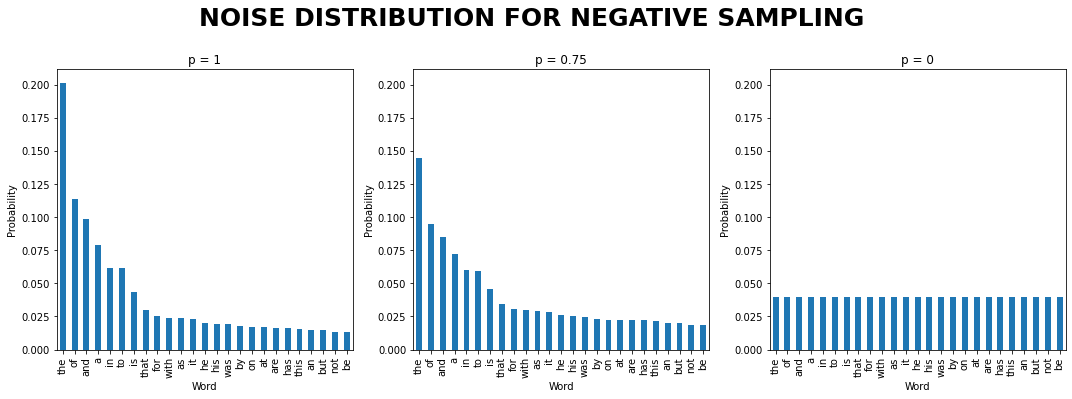

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

compare_p = [1, 0.75, 0]
compare_df = [generateWordFreqProbTable(brown_reviews_lower, alpha) for alpha in compare_p]

for idx, (ax, df) in enumerate(zip(axes, compare_df)):
  df.plot(kind = "bar", x = "Word", y = "Probability", ax = ax)
  ax.get_legend().remove()
  ax.set_ylim((0, 0.01 + compare_df[0].iloc[0]["Probability"]))
  ax.set_ylabel("Probability")
  ax.set_title(f"p = {compare_p[idx]}")

plt.tight_layout()
fig.suptitle("NOISE DISTRIBUTION FOR NEGATIVE SAMPLING ", size = 25, y = 1.1, fontweight = "bold")
plt.show()

### **Hierarchical Softmax**

Okay, with Negative Sampling we only updating certain weights in the output matrix independently, which loses the softmax behaviour. But how if we still want the model to learn the softmax behaviour?

Hierarchical softmax is a technique to approximate the value of softmax and preserve its behaviour. Output weights are now organized in a structure of **Huffman Coding Tree**.

<center><img src="https://raw.githubusercontent.com/tomytjandra/word2vec-embeddings/master/assets/huffman_tree.png" width="50%"></center>

It is a **full binary tree** with the following characteristics:
- Every internal node has exactly two branches of child node. The internal nodes are depicted with blue circles.
- The leaf node is the vocabulary word, depicted with orange circles.
- The number of internal node is always one less than the number of leaf node.
- The leaf nodes are ordered such that frequent words are located near the root node.

The approximated value will be less accurate, but the computational cost is more efficient. It reduces the complexity from $O(V)$ to $O(log_2{V})$.

To understand the construction of Huffman Coding Tree, see [Huffman Coding Visualization](https://people.ok.ubc.ca/ylucet/DS/Huffman.html). Note that the leaf nodes are  characters instead of a word. Try input the text `aaaabbbbcccdddefgh` to get a similar structure as the picture above.

## How does the training works?

The input matrix is still the same as a regular Word2Vec architecture. The main difference is on the output matrix. We treat each internal node as a column in the output matrix. Hence, the size of output matrix will be $N \times (V-1)$.

Suppose using the above huffman tree, we train a Skip-gram using the sample `(chupacabra, active)`.

<center><img src="https://raw.githubusercontent.com/tomytjandra/word2vec-embeddings/master/assets/huffman_tree_training.png" width="50%"></center>

The steps are:
1. Take the $N$-dimensional vector of hidden layer of the word `chupacabra`.
2. Travel along the huffman tree to locate the word `active`.
3. For each traversed node:
  - Compute the logit score, which is the dot product of the word vector with the corresponding column of output matrix.
  - Apply sigmoid activation function to get a probability. We treat this as $\hat{y}$.
  - The traversed branch/edge is treated as $y$.
4. Compute error and backpropagate, just like the original architecture.



## **Hyperparameter Tuning**

The hyperparameter choice is crucial for model performance, both speed and accuracy. However it varies for different applications. According to this [Google Code Archive](https://code.google.com/archive/p/word2vec/), the main choices to make are:

* Architecture:
  1. Skip-gram: better for rare words and small training set but slower
  2. CBOW: faster but bias toward frequent words

* Window size:
  1. Skip-gram usually around 10
  2. CBOW around 5

* Word vectors dimensionality: usually more is better, but not always

* Training optimization:
  1. Hierarchical softmax: better for infrequent words
  2. Negative sampling: better for frequent words, better with low dimensional vectors

* Sub-sampling frequent words: improve both accuracy and speed for large data sets (useful values are in range 0.1% to 0.001%)


# **Practical Word2Vec using Gensim and Elang on Wikipedia Articles**

**Gensim** is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community.

For more information: [Gensim Word2Vec Documentation](https://radimrehurek.com/gensim/models/word2vec.html)

Developed by Samuel Chan and me, **Elang** is an acronym that combines the phrases **Embedding (E)** and **Language (Lang)** Models. Its goal is to help NLP (natural language processing) researchers, Word2Vec practitioners, educators and data scientists be more productive in training language models and explaining key concepts in word embeddings.

For more information: [Elang Github Documentation](https://github.com/onlyphantom/elang)

## **Step 1. Gather Text Data**

1. Scrape Wikipedia articles by using `build_from_wikipedia` function, saved it to a .txt file.
2. Load the .txt file as list of sentences. One sentence represent the content of one article.


In [0]:
from elang.word2vec.builder import build_from_wikipedia

In [0]:
build_from_wikipedia(
    slug = "Animal", # scrape with query
    levels = 1, # levels of articles
    lang = "en", # english language
    model = False, # don't create model
    save = True) # save to txt file

Level 1 Queried so far: ['Insecta', 'Big_bug_movie', 'Scala_naturae', 'Nerve_tissue', 'Hemichordata', 'Parasite', 'Helminths', 'Vertebrates', 'Multicellular', 'Aerobic_respiration', 'Animal', 'Zoophytes', 'Animal_attacks', 'Triploblastic', 'Nematodes', 'Bivalve', 'Homeodomain', 'Protista', 'Canary_(bird)', 'Hierarchical', 'Unicellular', 'Cirripede', 'Alga', 'Mollusc', 'Feeding_behaviour', 'Diploblastic', 'Biological_tissue', 'Porifera', 'Late_Cambrian', 'Praying_mantis', 'Deuterostomes', 'Jean-Baptiste_de_Lamarck', 'Protostomes', 'Yondelis', 'Haploid', 'Gastropod', 'Crustacea', 'Extant_taxon', 'Consumer-resource_systems', 'Land_plant', 'Sinew', 'Working_animals', 'TGF-beta', 'Burgess_shale', 'Sense_organ', 'Amphibia', 'Embryogenesis', 'Cilia', 'Tardigrada', 'Gastrula', 'Spicule_(sponge)', 'Fossil_record', 'Prokaryotic', 'Titanosaur', 'Cephalisation', 'Eukaryotic', 'Classical_era', 'Signs_of_the_zodiac', 'Predator', 'Placozoan', 'Rouphozoa', 'Choanoflagellata', 'Philosophie_Zoologique',

In [0]:
wiki_file = open("/content/corpus/txt/wikipedia_branch_Animal_1.txt", "r")
wiki_text = wiki_file.readlines()
wiki_text[:5]

['    Insects or Insecta (from Latin insectum) are hexapod invertebrates and the largest group within the arthropod phylum. Definitions and circumscriptions vary; usually, insects comprise a class within the Arthropoda. As used here, the term Insecta is synonymous with Ectognatha. Insects have a chitinous exoskeleton, a three-part body (head, thorax and abdomen), three pairs of jointed legs, compound eyes and one pair of antennae. Insects are the most diverse group of animals; they include more than a million described species and represent more than half of all known living organisms.[2][3] The total number of extant species is estimated at between six and ten million;[2][4][5] potentially over 90% of the animal life forms on Earth are insects.[5][6] Insects may be found in nearly all environments, although only a small number of species reside in the oceans, which are dominated by another arthropod group, crustaceans.  Nearly all insects hatch from eggs. Insect growth is constrained 

## **Step 2. Preprocessing**

1. `contractions.fix()`: Replace contractions by expanding it. Example: I'm become I am.
2. `simple_preprocess()`: Remove numbers, punctuation, whitespace then return as lowercase tokens in list.
3. Remove stopwords, this is optional depends on the case.


Demonstrate what each function does:

In [0]:
import contractions
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [0]:
# EXAMPLE
example_sentence = "I'll arrive at the café around 9 PM. See you there! :)"
print(example_sentence)

# contractions.fix() 
sent = contractions.fix(example_sentence)
print(sent)

# simple_preprocess()
sent_list = simple_preprocess(sent, deacc = True) # list of tokens
print(' '.join(sent_list))

# optional: Remove stopwords
stopword_list = stopwords.words("english")
clean_sent_list = [word for word in sent_list if word not in stopword_list]
print(' '.join(clean_sent_list))

I'll arrive at the café around 9 PM. See you there! :)
I will arrive at the café around 9 PM. See you there! :)
will arrive at the cafe around pm see you there
arrive cafe around pm see


Let's clean our `wiki_text` (list of sentences) without removing the stopwords.



In [0]:
clean_wiki_text = list(map(contractions.fix, tqdm(wiki_text)))
#clean_wiki_text = list(map(simple_preprocess, clean_wiki_text)) # with no additional parameter
clean_wiki_text = [simple_preprocess(sentence, deacc = True) for sentence in tqdm(clean_wiki_text)] # with additional parameter

100%|██████████| 64/64 [00:00<00:00, 123.16it/s]


## **Step 3. Model Training**

Don't worry about the code below. We are setting up the logging settings to monitor the training process.

In [0]:
from time import time

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim.models.callbacks import CallbackAny2Vec
class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 1:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

Separate the training into **three distinctive steps**: 

`Word2Vec()`: Set up the parameters of the model one-by-one and leave the model uninitialized.

`.build_vocab()`: Builds the vocabulary from a sequence of sentences and thus initialized the model. 

`.train()`: Finally, trains the model. The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [0]:
from gensim.models import Word2Vec

model = Word2Vec(
    size = 300, # dimensionality of the word vectors
    window = 5, # max distance between context and target word
    min_count = 10, # frequency cut-off
    sg = 1, # skip-gram = 1, CBOW = 0
    cbow_mean = 0, # only applies to CBOW. Use 0 for sum, or 1 for mean of the word vectors 
    hs = 1, # not using hierarchical softmax
    negative = 20, # instead, use negative sampling with 20 negative samples and 1 positive sample
    ns_exponent = 0.75, # reshape the noise distribution of negative sampling (p)
    alpha = 0.005, # backpropagation learning rate
    seed = 123, # reproducibility
    workers = 1)

print(model)

Word2Vec(vocab=0, size=300, alpha=0.005)


In [0]:
logging.disable(logging.NOTSET) # enable logging
t = time()

model.build_vocab(clean_wiki_text, progress_per = 100)

print('Time to build vocab: {} seconds'.format(round((time() - t), 2)))

2020-04-21 08:42:38,065 : INFO : collecting all words and their counts
2020-04-21 08:42:38,066 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-21 08:42:38,107 : INFO : collected 17525 word types from a corpus of 187489 raw words and 64 sentences
2020-04-21 08:42:38,110 : INFO : Loading a fresh vocabulary
2020-04-21 08:42:38,207 : INFO : effective_min_count=10 retains 2450 unique words (13% of original 17525, drops 15075)
2020-04-21 08:42:38,208 : INFO : effective_min_count=10 leaves 153644 word corpus (81% of original 187489, drops 33845)
2020-04-21 08:42:38,221 : INFO : deleting the raw counts dictionary of 17525 items
2020-04-21 08:42:38,222 : INFO : sample=0.001 downsamples 46 most-common words
2020-04-21 08:42:38,222 : INFO : downsampling leaves estimated 109736 word corpus (71.4% of prior 153644)
2020-04-21 08:42:38,228 : INFO : constructing a huffman tree from 2450 words
2020-04-21 08:42:38,281 : INFO : built huffman tree with maximum node depth

Time to build vocab: 0.75 seconds


In [0]:
logging.disable(logging.INFO) # disable logging
callback = Callback() # instead, print out loss for each epoch
t = time()

model.train(clean_wiki_text,
            total_examples = model.corpus_count, # count of sentences
            epochs = 10, # number of iterations over the corpus,
            compute_loss = True, # to track model loss
            callbacks = [callback]) 

print('Time to train the model: {} seconds'.format(round((time() - t), 2)))

Loss after epoch 1: 8712558.0
Loss after epoch 2: 8204748.0
Loss after epoch 3: 4327134.0
Loss after epoch 4: 4215556.0
Loss after epoch 5: 4094404.0
Loss after epoch 6: 3943968.0
Loss after epoch 7: 2950096.0
Loss after epoch 8: 2920060.0
Loss after epoch 9: 2927080.0
Loss after epoch 10: 2943032.0
Time to train the model: 50.64 seconds


In [0]:
print(model)

Word2Vec(vocab=2450, size=300, alpha=0.005)


We can save the trained model using `.save()` method

In [0]:
# model.save("wiki_Animal.model")

Load the pre-trained model using `.load()` method. I trained the model using `wikipedia_branch_Animal_3.txt` for a good 1.5 - 2 hours.

In [0]:
model = Word2Vec.load("wiki_Animal.model")
print(model)

Word2Vec(vocab=23190, size=300, alpha=0.005)


## **Step 4. Visualize**

The visualization can be useful to understand how Word2Vec works and how to interpret relations between vectors captured from your texts before using them in other machine learning algorithms. By using `elang`, dimensionality reduction is performed on each word vectors in order to create the two-dimensional plot.


In [0]:
from elang.plot.utils import plot2d, plotNeighbours

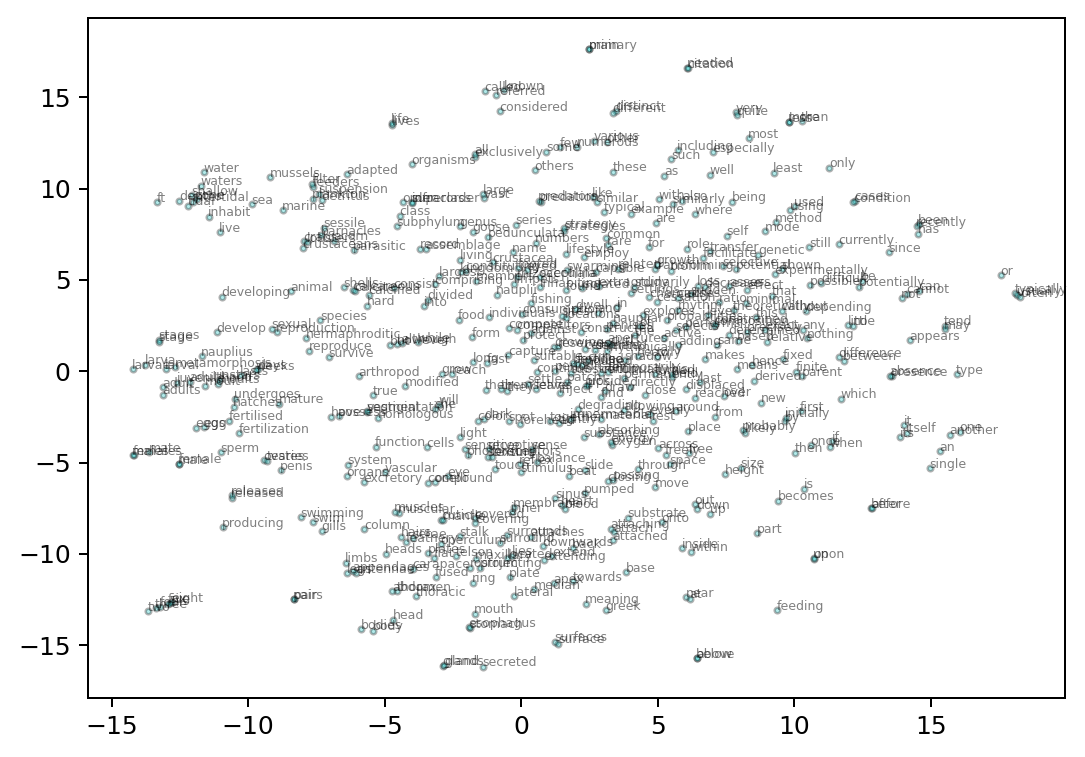

In [0]:
plot2d(model, method = "TSNE", random_state = 123)

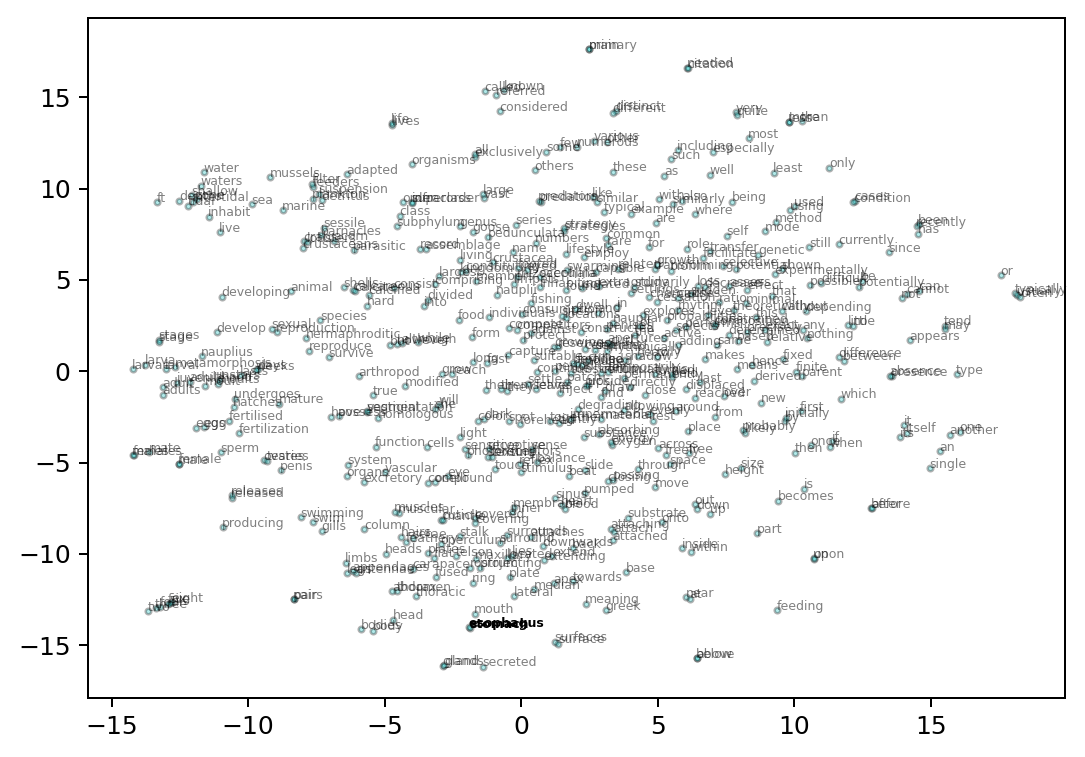

In [0]:
similar_w = [w[0] for w in model.wv.most_similar("mouth", topn = 20)]
plot2d(model, targets = similar_w, method = "TSNE", random_state = 123)

Words that have similar meaning (by cosine similarity) tend to plotted next to each other. Therefore, creating a word clusters.

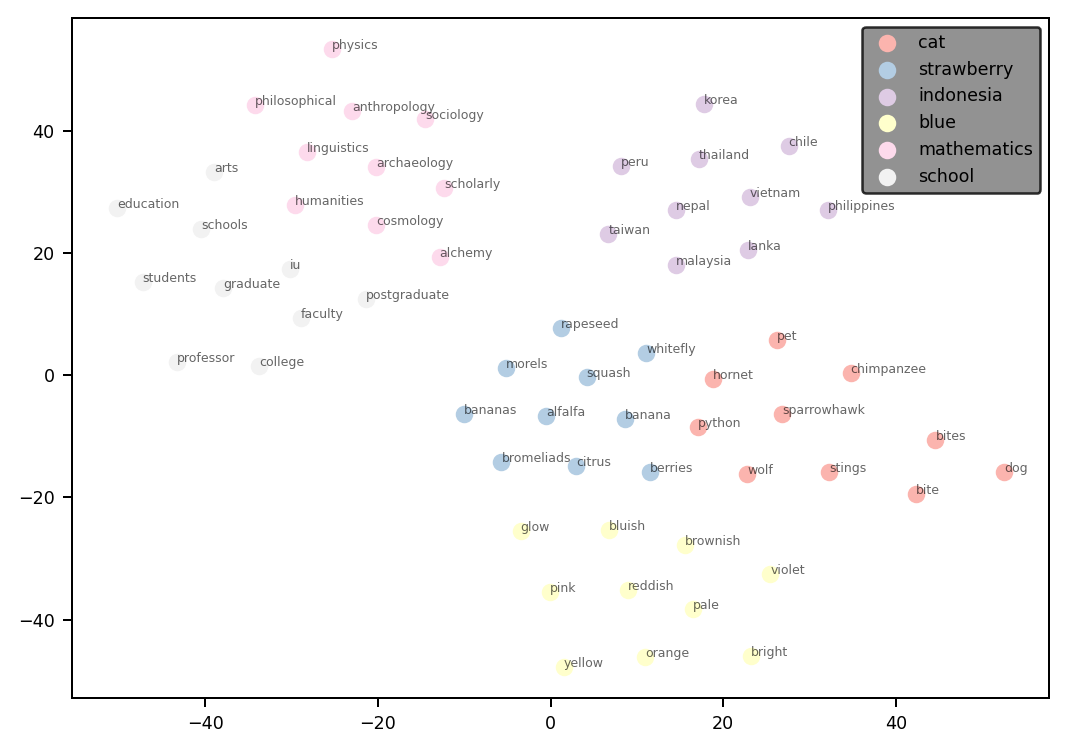

In [0]:
plotNeighbours(model, words = ["cat", "strawberry", "indonesia", "blue", "mathematics", "school"],
               method = "TSNE", k = 10, 
               random_state = 123, draggable = True)

| WORD | COLOR | CATEGORY |
| --- | --- | --- |
| cat | red | animal |
| strawberry | blue | fruit/plant |
| indonesia | violet | country |
| blue | yellow | color |
| mathematics | pink | field of study |
| school | light blue | academic-related |

## **Step 5. Using the Word2Vec model**

**VOCABULARY LIST** 

The list of vocabulary is saved on `model.wv.vocab`

In [0]:
list(model.wv.vocab)[:10]

['barnacle',
 'is',
 'type',
 'of',
 'arthropod',
 'constituting',
 'the',
 'infraclass',
 'in',
 'subphylum']

**WORD VECTORS**

Check the dimensionality and content of a word vector.

In [0]:
vec = model.wv["dog"]
len(vec)

300

**MOST SIMILAR WORDS**

List out `topn` similar words based on Cosine Similarity.

In [0]:
model.wv.most_similar("dog", topn = 5)

[('bites', 0.8471914529800415),
 ('bite', 0.8361319303512573),
 ('cat', 0.8241820335388184),
 ('dogs', 0.7486913204193115),
 ('pet', 0.7360792756080627)]

**OUT-OF-LIST WORD**

From a list of words, word vectors can choose one word that has different context among the rest.

In [0]:
model.wv.doesnt_match(['dog', 'cat', 'wolf', 'human', 'eagle'])

'human'

In [0]:
model.wv.doesnt_match(['orange', 'red', 'banana', 'blue', 'white'])

'banana'

**WORD RELATIONSHIP**

The word vectors can capture word relationship for example:

`apple - red = ... - yellow`

A proper word for this is a fruit with a yellow color.

In [0]:
model.wv.most_similar(positive = ['apple', 'yellow'], negative = ['red'])

[('pepper', 0.7986029982566833),
 ('cabbage', 0.7931523323059082),
 ('bean', 0.7775619029998779),
 ('pink', 0.776929497718811),
 ('rot', 0.7747037410736084),
 ('brassica', 0.7720001935958862),
 ('mustard', 0.7547014951705933),
 ('citrus', 0.7532116770744324),
 ('blister', 0.7486450672149658),
 ('oak', 0.7483341693878174)]

# **Case Study: Recommender System**

<center><img src="https://miro.medium.com/max/2000/1*rCK9VjrPgpHUvSNYw7qcuQ@2x.png"></center>

**Content-based:**

(+) Suffer less from the **cold start problem** than collaborative approaches: new users or items can be described by their characteristics (content) and so relevant suggestions can be done for these new entities.

(-) Tend to **over-specialize**: it will recommend items similar to those already consumed, with a tendency of creating a "filter bubble".

**Collaborative:**

(+) Require no information about users or items and, so can be used in many situations. 

(+) More accurate recommendations, since new interactions recorded over time bring new information and make the system more effective.

(-) **Cold start problem**: Impossible to recommend items to new users or to recommend a new item to any users and many users or items have too few interactions to be efficiently handled.



## **Google Colab Link**

We'll be using collaborative, memory-based method for our case study. Let's go:

> **Non-Textual Data Case Study, Using Word2vec for Online Product Recommender System**

> https://colab.research.google.com/drive/1gkbX3i0ee35rLL4_DzHCmpSC6OPoACF8

# **Potential Uses**

## **NLP Applications**

Word2Vec is used as an input to other neural network architecture for:
* Article Classification
* Machine Translation
* Auto Image Captioning
* Chatbot
* Text Summarization
* and many more...

## **Other Non-NLP Use Case: Recommender and Advertising**

### 1. Music Recommender at Spotify and Anghami

A user’s **listening queue** can be used to learn song vectors in the same way that a string of words in text is used to learn word vectors. The assumption is that users will tend to listen to similar tracks in sequence.

<center><img src="http://mccormickml.com/assets/word2vec_apps/Spotify_user_activity.png" width="50%"></center>

How these song vectors are then used? One use is to create a kind of **music taste** vector for a user by averaging together the vectors for songs that a user likes to listen to. This taste vector can then become the query for a similarity search to find songs which are similar to the user’s taste vector.

<center><img src="https://cdn-images-1.medium.com/max/1400/1*xbNM_CnEIWQtGbsLmZtE-A.gif", width="75%"></center>

### 2. Listing Recommendations at Airbnb

Imagine you are looking for an apartment to rent for your vacation to Paris. As you browse through the available homes, it’s likely that you will investigate a number of listings which fit your preferences and are comparable in features like amenities and design taste.

Here the user activity data takes the form of **click data**, specifically the sequence of listings that a user viewed. Airbnb is able to learn vector representations of their listings by applying the word2vec approach to this data.

<center><img src="http://mccormickml.com/assets/word2vec_apps/Airbnb_user_activity.png", width="75%"></center>

An important piece of the word2vec training algorithm is that for each word that we train on, we select a random handful of words (which are not in the context of that word) to use as **negative samples**. Airbnb found that in order to learn vectors which could distinguish listings within Paris (and not just distinguish Paris listings from New York listings), it was important that the negative samples be drawn from within Paris.

Their solution to the **cold start problem** is to simply averaged the vectors of the geographically closest three listings to the new listing to create an initial vector.

### 3. Product Recommendations in Yahoo Mail

Yahoo use **purchase receipts** in a user’s email inbox to form a purchase activity, allowing them in turn to learn product feature vectors which can be used to make product recommendations. 

Since online shoppers receive e-mail receipts for their purchases, mail clients are in a unique position to see user purchasing activity across many different e-commerce sites. Even without this advantage, though, Yahoo’s approach seems applicable and potentially valuable to online retailers as well.

<center><img src="http://mccormickml.com/assets/word2vec_apps/gmail_purchase_receipts.png", 
width="75%"></center>

Yahoo augmented the word2vec approach with a few notable innovations. The most interesting to me was their use of **clustering** to promote diversity in their recommendations. After learning vectors for all the products in their database, they clustered these vectors into groups. When making recommendations for a user based on a product the user just purchased, they don’t recommend products from within the same cluster. Instead, they identify which other clusters users most often purchase from after purchasing from the current cluster, and they recommend products from those other clusters instead.

<center><img src="http://mccormickml.com/assets/word2vec_apps/Cluster_recommendations.png", 
width="60%"></center>

Example: After purchasing a product from the Nerf cluster, customers are most likely to purchase a product from either the Xbox, Pokemon, or LEGO clusters.

### 4. Matching Ads to Search Queries on Yahoo Search

The goal is to learn vector representations for search queries and for advertisements in the same **embedding space**, so that a given search query can be matched against available advertisements in order to find the most relevant ads to show the user.

The training data consists of user **search sessions** which consist of search queries entered, advertisements clicked, and search result links clicked. The sequence of these user actions is treated like the words in a sentence, and vectors are learned for each of them based on their context–the actions that tend to occur around them. If users often click a particular ad after entering a particular query, then we’ll learn similar vectors for the ad and the query. All three types of actions (searches entered, ads clicked, links clicked) are part of a single “vocabulary” for the model, such that the model doesn’t really distinguish these from one another.

<center><img src="http://mccormickml.com/assets/word2vec_apps/search_activity.png", 
width="50%"></center>

## **Extension to Word2Vec**
### **Doc2Vec**

Doc2Vec is an extension of Word2vec that encodes entire documents as opposed to individual words. Doc2Vec vectors represent the theme or overall meaning of a document. In this case, a document is a sentence, a paragraph, an article or an essay etc. Similar to Word2vec, there are two primary training methods: **Distributed Memory Model Of Paragraph Vectors (PV-DM)** and **Paragraph Vector With A Distributed Bag Of Words (PVDBOW)**.

### **Dna2Vec**

<center><img src="https://raw.githubusercontent.com/tomytjandra/word2vec-embeddings/master/assets/dna2vec.png" width="75%"></center>

Dna2Vec is a consistent vector representations of variable-length k-mers. The analogies between natural language and DNA are as follow:
  - K-mer as the Words
  - DNA fragments as the Sentences
  - Part/whole of genome as the Corpus


### **FastText**

FastText is  proposed by Facebook in 2016. Instead of feeding individual words into the Neural Network, FastText breaks words into several n-grams (sub-words). For instance, the tri-grams for the word apple is app, ppl, and ple. The word embedding vector for apple will be the sum of all these n-grams. After training the Neural Network, we will have word embeddings for all the n-grams given the training dataset.

Rare words can now be properly represented since it is highly likely that some of their n-grams also appears in other words. Even though a word does not exist in the training dataset, the model still capable of figuring out this word is closely related to similar terms.

<center><img src="https://i.pinimg.com/originals/9c/e0/4c/9ce04c7ddeef0b9abae7f085255cdef1.gif" width="30%"></center>
<center><b>Thank you for attending my internal training.</b></center>

# **References**

Here are some further readings about Word2Vec:

* Word Embedding and Word2Vec

[Towards Data Science: Introduction to Word Embedding and Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)

[Python Notebook: Understanding Word Vectors](https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469)

[Machine Learning Plus: Cosine Similarity](https://www.machinelearningplus.com/nlp/cosine-similarity/)

[Towards Data Science: NLP 101 Word2Vec Skip-gram and CBOW](https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314)

[Medium: Word Embedding](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)

[mc.ai: Understand the Softmax Function in Minutes](https://mc.ai/understand-the-softmax-function-in-minutes/)

[Youtube: Hierarchical Softmax in Word2vec](https://www.youtube.com/watch?v=pzyIWCelt_E)

* Recommender System

[Towards Data Science: Introduction to Recommender Systems](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada)

[Analytics Vidhya: Building a Recommendation System using Word2vec](https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/)

* Potential Uses

[Chris McCormick: Applying Word2vec to Recommenders and Advertising](http://mccormickml.com/2018/06/15/applying-word2vec-to-recommenders-and-advertising/)

[mc.ai: An Intuitive Introduction Of Document Vector (Doc2Vec)](https://mc.ai/an-intuitive-introduction-of-document-vectordoc2vec/)

[arXiv Paper: dna2vec](https://arxiv.org/pdf/1701.06279.pdf)

[Data Science Hongkong: Application of  Word2Vec to Represent Biological Sequences](https://datasciencehongkong.files.wordpress.com/2018/02/dna2vec.pdf)

[Towards Data Science: Word2Vec and FastText Word Embedding with Gensim](https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c)

In [0]:
import random
product_team = ['Ajeng', 'Arga', 'David', 'Fafilia', 'Handoyo', 'Husain', 'Inayatus', 'Iqbal', 'Joe', 'Lita', 'Nabiilah', 'Shello', 'Sitta', 'Tanesya', 'Tiara', 'Wulan']
random.choice(product_team)